In [28]:
from icecream import ic
import pandas as pd
# from dhs_preprocessing_functions import *
# from pandarallel import pandarallel
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import os
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import xgboost as xgb
from keras import regularizers
from collections import defaultdict
from sklearn.linear_model import LinearRegression


%matplotlib inline
# Initialization
# pandarallel.initialize()


from dhs_modelling_functions import *

In [29]:
# to dos:
# 1. add a function to plot the feature importance
# 2. add a function to plot the partial dependence plots
# 3. implement train, val test in modeling function
# 4. use r2 score as a loss function



In [30]:
input_dir = "/mnt/datadisk/data/Projects/water/inputs/"
out_dir = input_dir + 'country_data_cross_val_results/'
# min_version = 3
overwrite_pqt = True
dataset_type = 'HR'  #, 'BR', 'CR', 'HW', 'IR', 'KR', 'MR', 'PR', 'AR'] ??['AN', 'FC, 'FP', 'HW', 'PV', 'SC'] < 25 surveys
urban_rural_all_mode = 'all' # 'all', 'U', 'R'
group_by_col = 'adm2_gaul'
# out_f = f"{input_dir}5_grouped_df_V3_{dataset_type}_{group_by_col}_joined_with_ipc_{urban_rural_all_mode}.pkl"

# Scale options
scale_numerical_data = False
scale_all_data = True
leave_out_encodings = False
zero_one_scale_categorical = False
scale_labels = True

# More Options
drop_agriculture = False
use_pca = False
drop_encodings = False
load_best_model = True
use_3_layer_nn = True 
neurons_first_layer = 256
add_dropout = False
regularizer_type = False
regularizer_value = 0.05
add_n = 'imputed_L2_0.5'
use_imputations = False
model_n = 'linear' # nn, linear or xgb
fold_by = 'country' # country, year, survey or unconditional
print_col = 'Meta; adm0_gaul'
drop_perc = 20
epochs = 100
use_sustainbench = False
test_mode = False
use_fs_as_input = True
test_function_to_use = 'mse' #correlation, rmse, r2, mse
use_additional_subset = True

# Combine these into a dict for results.csv
options = {
    'scale_numerical_data': scale_numerical_data,
    'scale_all_data': scale_all_data,
    'leave_out_encodings': leave_out_encodings,
    'zero_one_scale_categorical': zero_one_scale_categorical,
    'scale_labels': scale_labels,
    'drop_agriculture': drop_agriculture,
    'use_pca': use_pca,
    'drop_encodings': drop_encodings,
    'load_best_model': load_best_model,
    'use_3_layer_nn': use_3_layer_nn,
    'add_dropout': add_dropout,
    'regularizer': regularizer_type,
    'regularizer_value': regularizer_value,
    'add_n': add_n,
    'use_imputations': use_imputations,
    'model_n': model_n,
    'fold_by': fold_by,
    'print_col': print_col,
    'drop_perc': drop_perc,
    'epochs': epochs,
    'use_sustainbench': use_sustainbench,
    'test_mode': test_mode,
    'use_fs_as_input': use_fs_as_input,
    'test_function_to_use': test_function_to_use,
    'use_additional_subset': use_additional_subset,
    'neurons_first_layer': neurons_first_layer,
}

#Other Options
overwrite_results = False
write_PDP_plots = False


# in_f = f"{input_dir}5_grouped_df_V3_{dataset_type}_{group_by_col}_joined_with_ipc_{urban_rural_all_mode}.pkl"
in_f = f"{input_dir}GDP_CPI_weoapr_preprocessed.csv"

# in2 = f"{input_dir}imputation_results_fold_by_survey_mask_categoricals_together_True_split_categoricals_False_drop_perc_19_MICE KNN_DF_imputed.csv"

# result_picture_f =
result_csv_f = f"{out_dir}results.csv"

In [31]:
if in_f[-4:] == '.pkl':
    input_df = pd.read_pickle(in_f)
else:
    input_df = pd.read_csv(in_f)
    
for c in input_df.columns:
    if 'year' in c or 'Year' in c:
        print(c)

# if urban_rural_all_mode == 'U':
#     drop_agriculture = True

drop_ds1, retrieve_ds = [], []
if drop_encodings:
    drop_ds1 = ['Meta one-hot encoding', 'Meta frequency encoding']
if use_sustainbench:
    retrieve_ds = ['DHS Sustainbench', 'FS']
df = final_ds_droping_cols(input_df, drop_meta=False, drop_food_help=True, drop_perc=drop_perc,
                           retain_month=False, drop_highly_correlated_cols=False, drop_region=True, 
                 drop_data_sets=drop_ds1, 
                 use_NAN_amount_and_replace_NANs_in_categorical=False, drop_agricultural_cols=drop_agriculture, 
                 drop_below_version=False, numerical_data=['mean'], retain_adm=False, retrieve_ds=retrieve_ds, 
                 retain_GEID_init=True, verbose=3)

# drop_cols = [c for c in df.columns if 'mean perc. change' in c and not '05' in c]
# df.drop(columns=drop_cols, inplace=True)

for col in df.columns:
    print(col)

Meta; year
gdp_cpi_weoapr; current account balance - percent of gdp: mean perc. change 01 years
gdp_cpi_weoapr; current account balance - percent of gdp: mean perc. change 02 years
gdp_cpi_weoapr; current account balance - percent of gdp: mean perc. change 05 years
gdp_cpi_weoapr; current account balance - percent of gdp: mean perc. change 10 years
gdp_cpi_weoapr; current account balance - percent of gdp: mean perc. change 15 years
gdp_cpi_weoapr; current account balance - u.s. dollars - billions: mean perc. change 01 years
gdp_cpi_weoapr; current account balance - u.s. dollars - billions: mean perc. change 02 years
gdp_cpi_weoapr; current account balance - u.s. dollars - billions: mean perc. change 05 years
gdp_cpi_weoapr; current account balance - u.s. dollars - billions: mean perc. change 10 years
gdp_cpi_weoapr; current account balance - u.s. dollars - billions: mean perc. change 15 years
gdp_cpi_weoapr; general government gross debt - percent of gdp: mean perc. change 01 years
gdp

In [32]:
missing_mask = False
if use_imputations:
    df_imputed = pd.read_csv(in2).drop(columns=['Unnamed: 0'])
    use_cols = [c for c in df_imputed.columns if c in df.columns]
    # Create a mask of missing values
    missing_mask = df[use_cols].isna()
    df = pd.concat([df.drop(columns=use_cols), df_imputed[use_cols]], axis=1)
else:
    missing_mask = df.isna()
    

In [33]:
# Define RMSE
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

def r_squared_loss(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    r2 = 1 - SS_res/(SS_tot + K.epsilon())
    return -r2

def negative_correlation(y_true, y_pred):
    y_true_centered = y_true - K.mean(y_true)
    y_pred_centered = y_pred - K.mean(y_pred)
    corr_num = K.sum(y_true_centered * y_pred_centered)
    corr_den = K.sqrt(K.sum(K.square(y_true_centered)) * K.sum(K.square(y_pred_centered)))
    corr_coef = corr_num / (corr_den + K.epsilon())
    return -corr_coef

if test_function_to_use == 'correlation':
    loss_function = negative_correlation
elif test_function_to_use == 'rmse':
    loss_function = root_mean_squared_error
elif test_function_to_use == 'r2':
    loss_function = r_squared_loss
elif test_function_to_use == 'mse':
    loss_function = 'mean_squared_error'

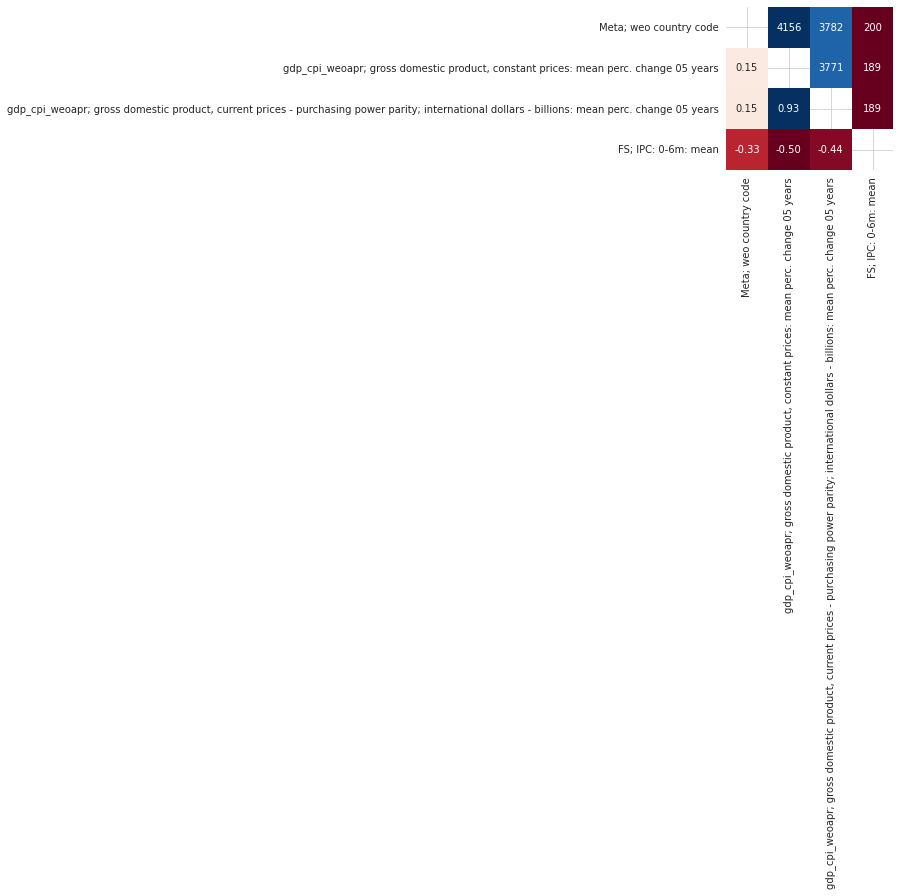

label_cols ['FS; IPC: 0-6m: mean', 'FS; IPC: 0-2y: mean', 'FS; IPC: 2-6y: mean', 'FS; IPC: 6-12y: mean', 'FS; IPC: 12-20y: mean']
num_cols []
input_df2 Index(['Meta; adm0_gaul', 'Meta; weo country code',
       'gdp_cpi_weoapr; gross domestic product, constant prices: mean perc. change 05 years',
       'gdp_cpi_weoapr; gross domestic product, current prices - purchasing power parity; international dollars - billions: mean perc. change 05 years'],
      dtype='object')
0 FS; IPC: 0-6m: mean 4875
lens 189 189
cols 4
0
train set ['Kenya' 'Malawi' 'Mali' 'Mauritania' 'Mozambique' 'Zimbabwe'
 'Burkina Faso' 'Zambia' 'Rwanda' 'Yemen' 'Guinea' 'Liberia' 'Somalia'
 'Democratic Republic of the Congo' 'Burundi' 'Cameroon']
val set ['Chad' 'Ethiopia' 'United Republic of Tanzania' 'Madagascar'
 'South Sudan']
test set ['Djibouti' 'Niger' 'Nigeria' 'Sudan' 'Uganda' 'Sierra Leone']
Shapes (105, 4) (34, 4) (50, 4)
0 train


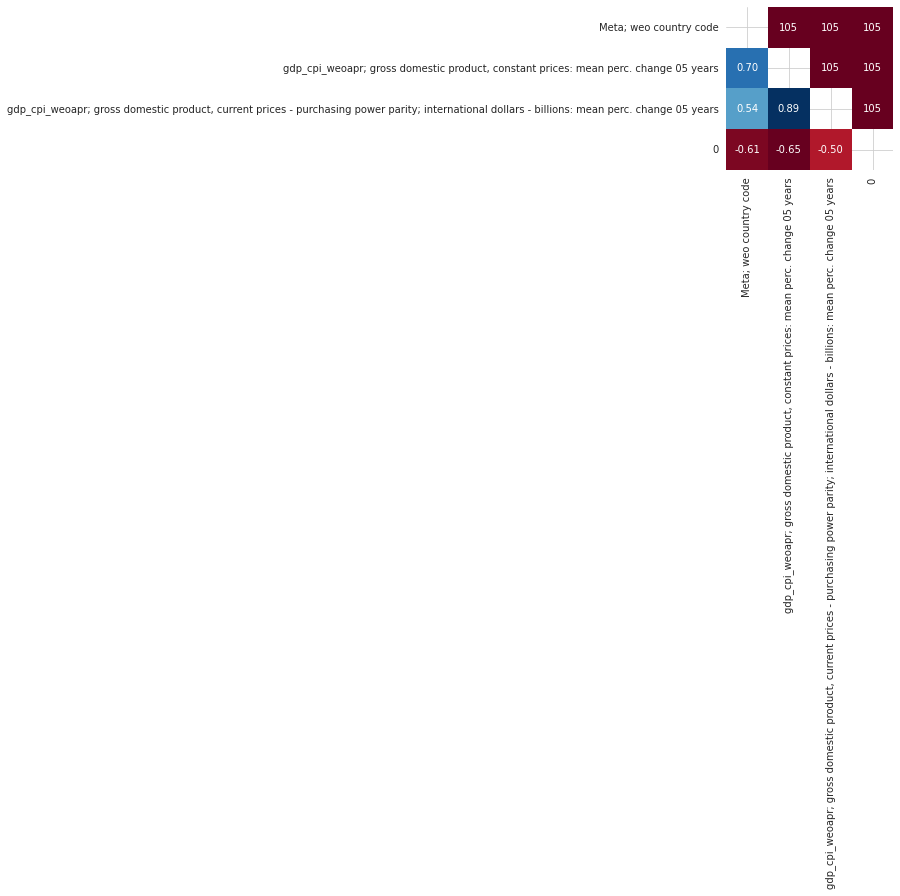

0 val


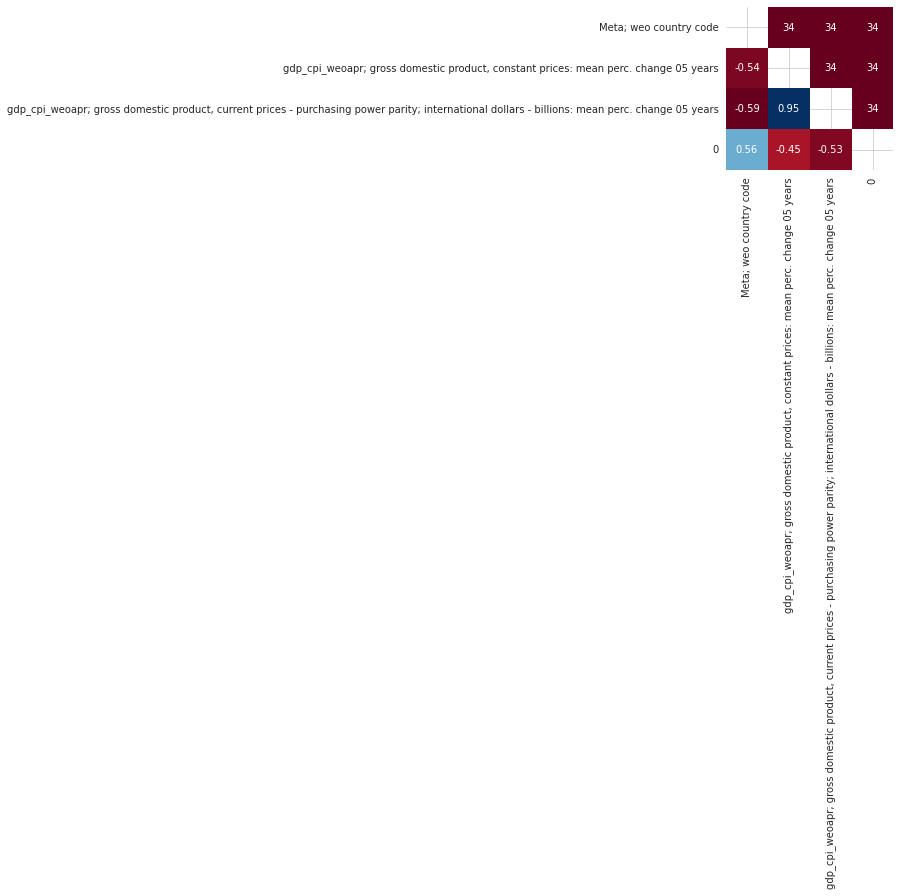

0 test


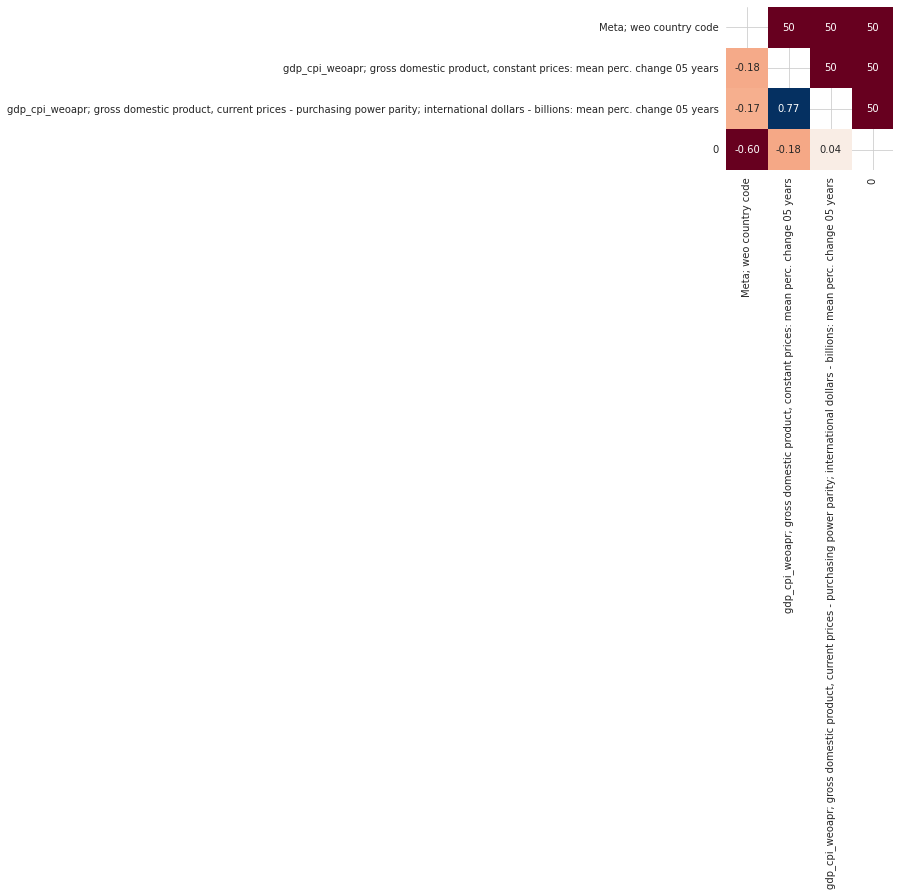

0 all


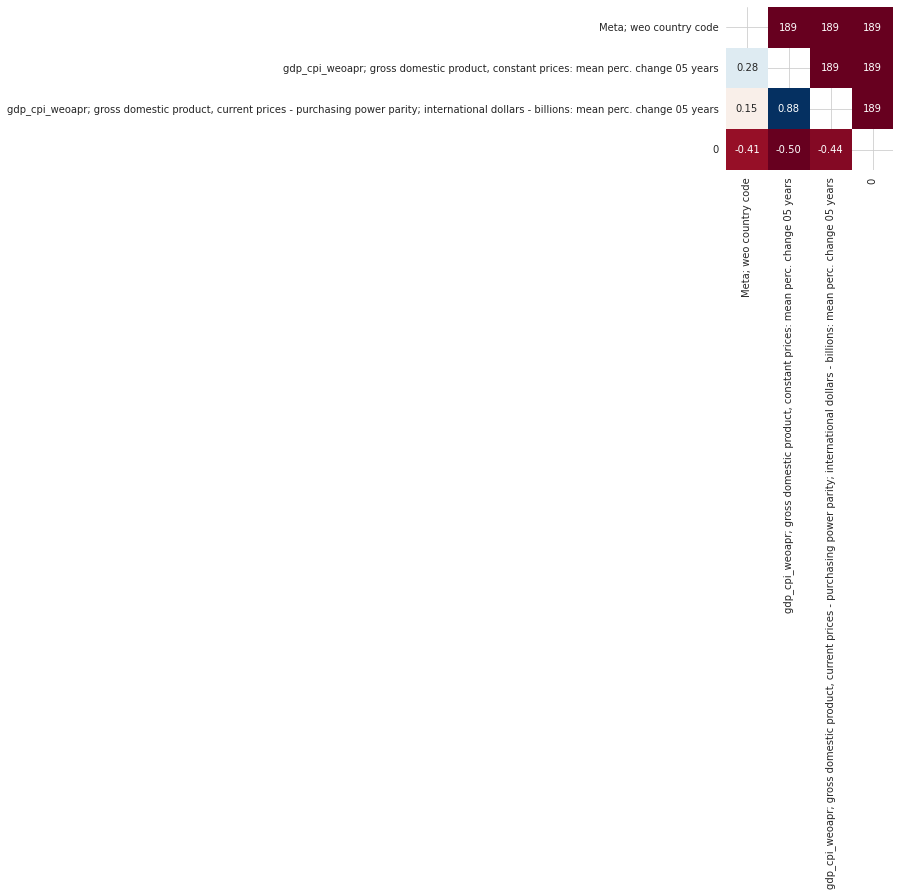

1
train set ['Kenya' 'Mali' 'Mauritania' 'Mozambique' 'Niger' 'Nigeria' 'Sudan'
 'Uganda' 'Burkina Faso' 'Zambia' 'Guinea' 'Liberia' 'Sierra Leone'
 'South Sudan' 'Burundi' 'Cameroon']
val set ['Djibouti' 'Ethiopia' 'Zimbabwe' 'Madagascar' 'Somalia']
test set ['Chad' 'Malawi' 'United Republic of Tanzania' 'Rwanda' 'Yemen'
 'Democratic Republic of the Congo']
Shapes (114, 4) (37, 4) (38, 4)
1 train


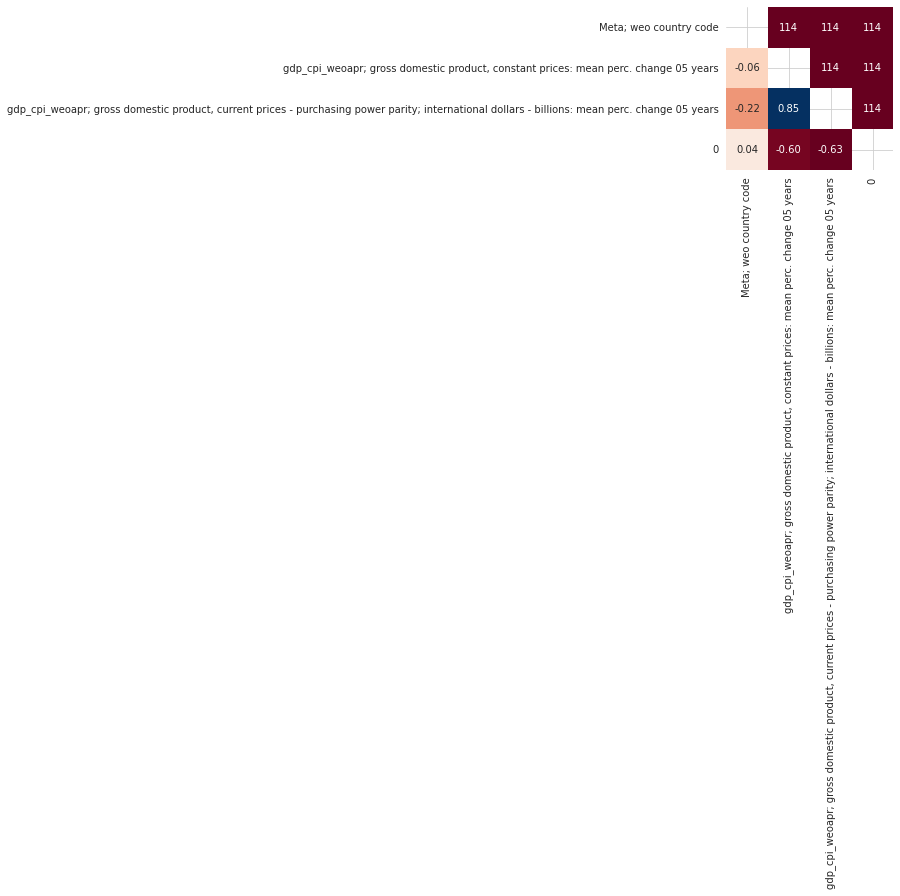

1 val


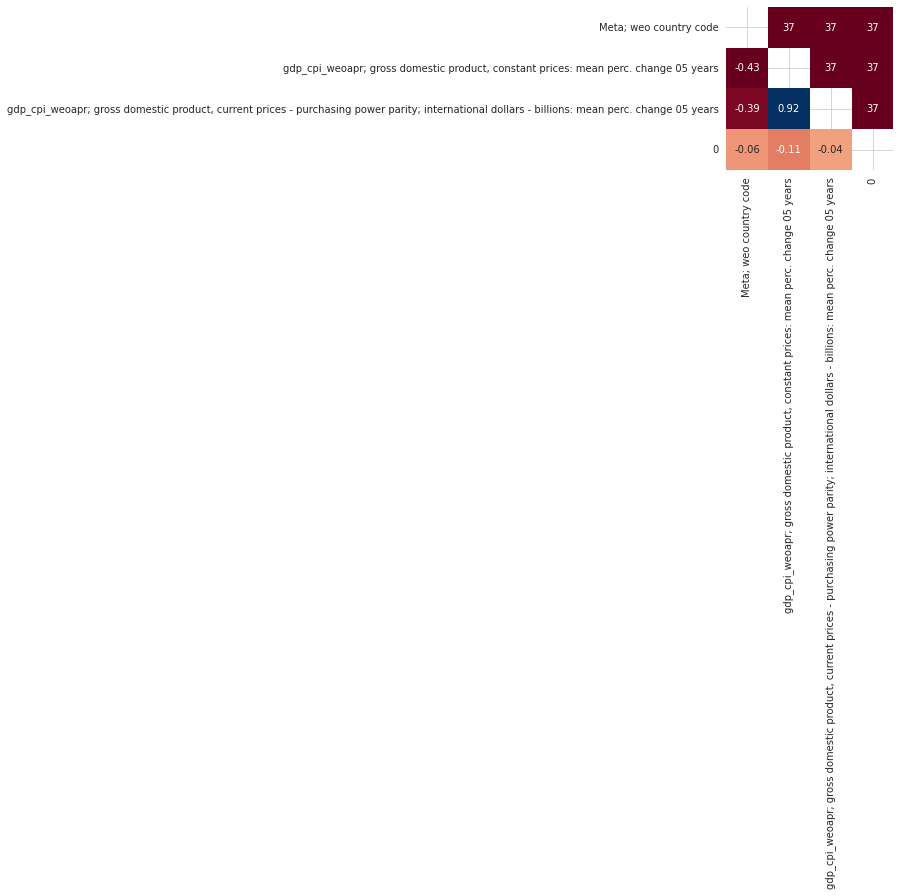

1 test


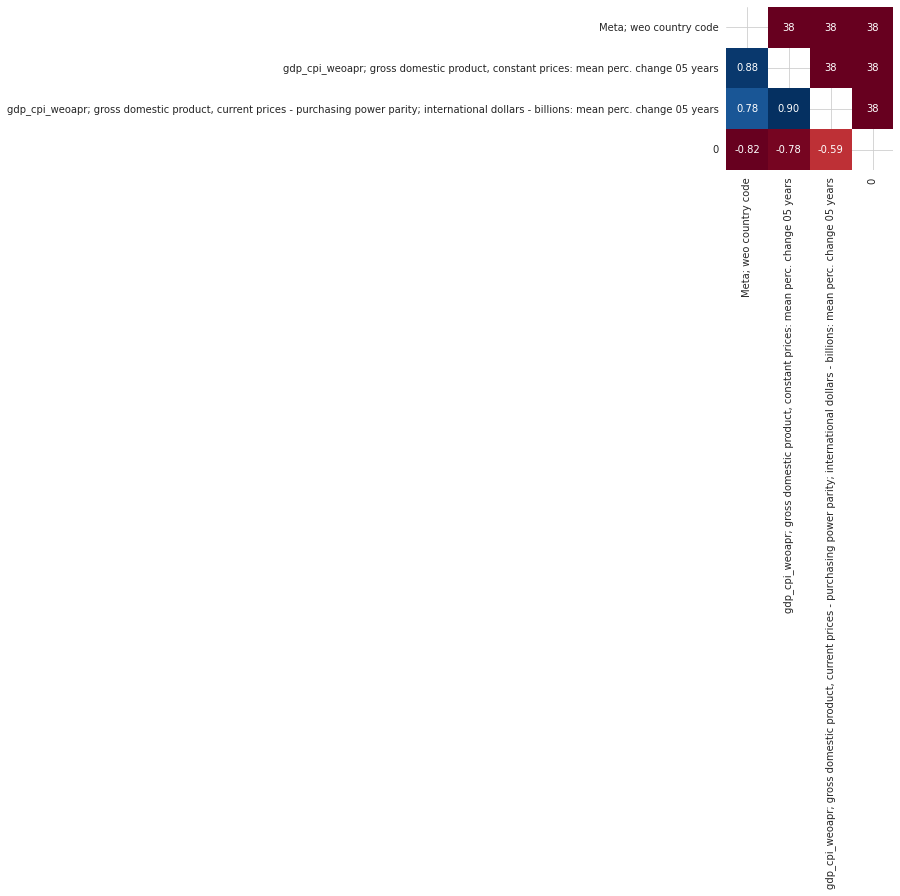

1 all


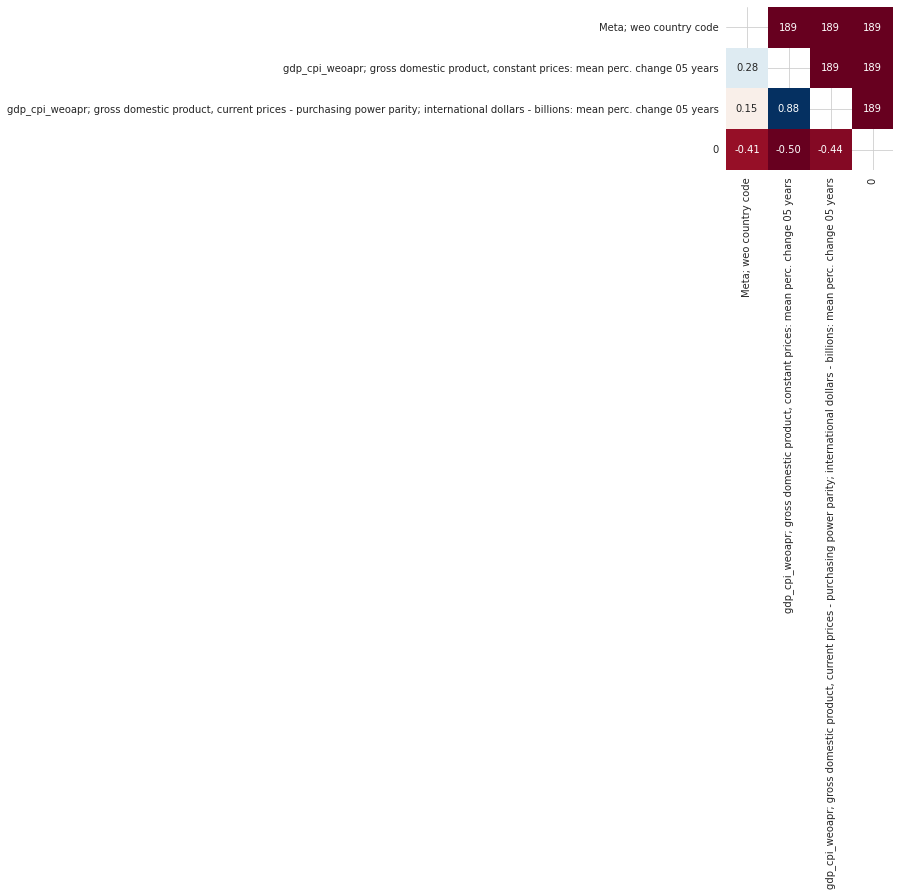

2
train set ['Malawi' 'Mauritania' 'Mozambique' 'Niger' 'Nigeria' 'Zimbabwe'
 'United Republic of Tanzania' 'Uganda' 'Burkina Faso' 'Rwanda' 'Guinea'
 'Madagascar' 'Sierra Leone' 'South Sudan'
 'Democratic Republic of the Congo' 'Burundi' 'Cameroon']
val set ['Djibouti' 'Chad' 'Sudan' 'Yemen' 'Liberia']
test set ['Ethiopia' 'Kenya' 'Mali' 'Zambia' 'Somalia']
Shapes (108, 4) (35, 4) (46, 4)
2 train


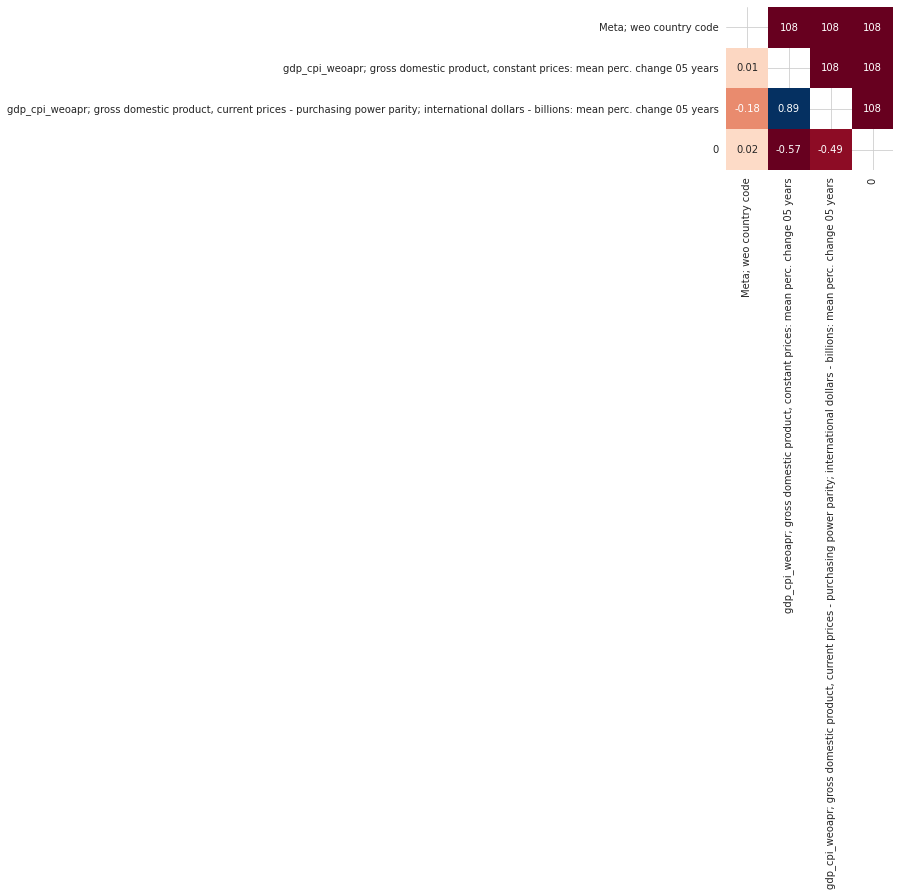

2 val


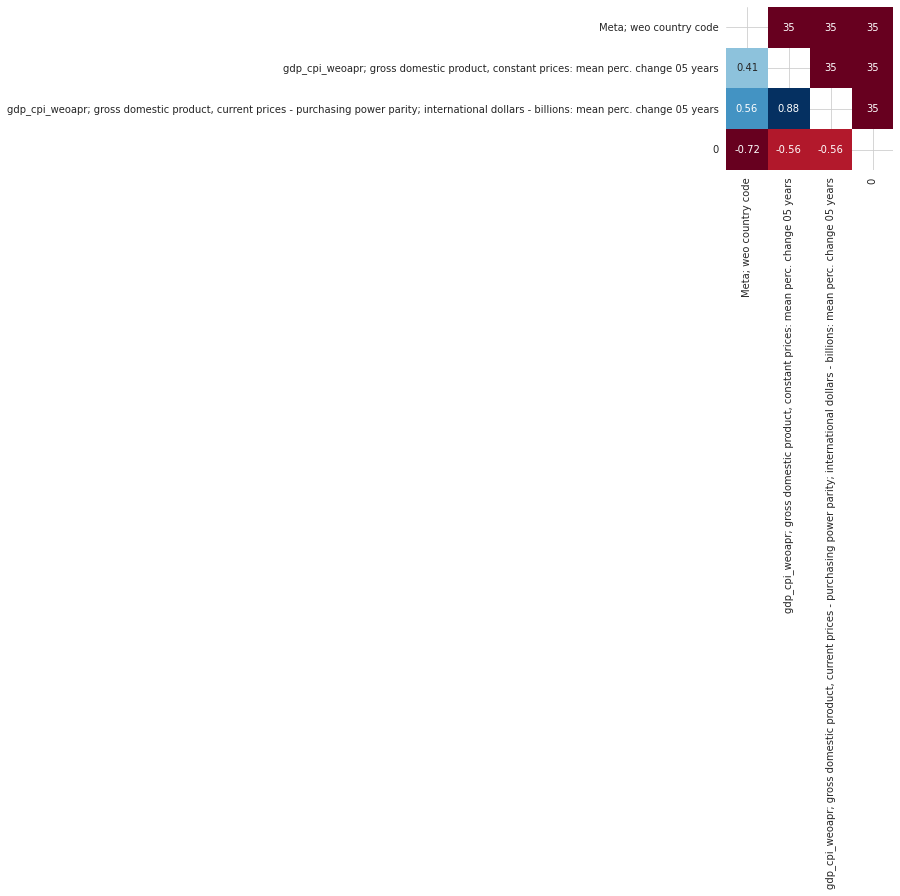

2 test


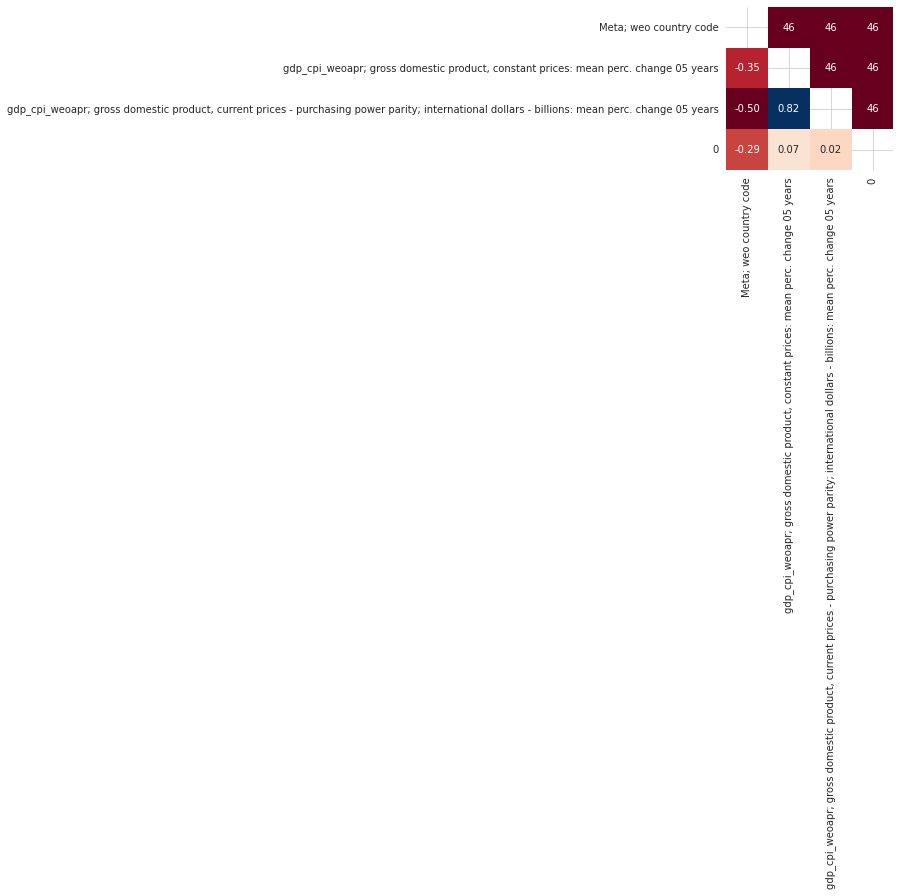

2 all


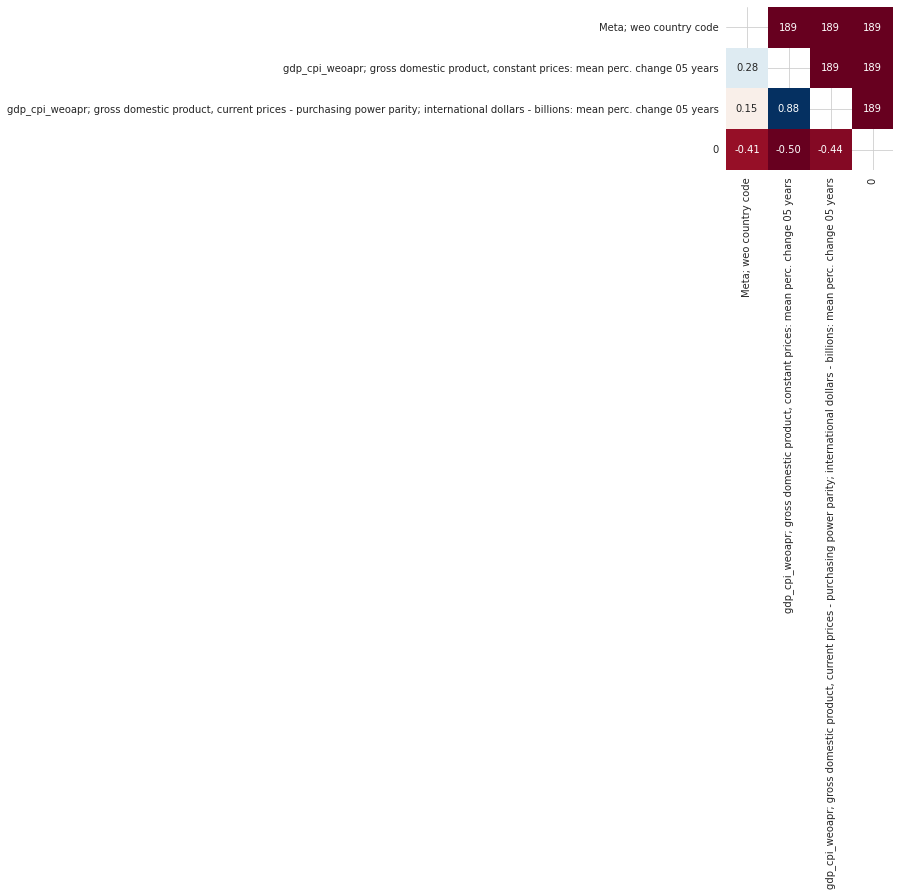

3
train set ['Ethiopia' 'Kenya' 'Malawi' 'Mali' 'Mauritania' 'Mozambique' 'Nigeria'
 'Zimbabwe' 'Sudan' 'United Republic of Tanzania' 'Burkina Faso' 'Rwanda'
 'Yemen' 'Liberia' 'Sierra Leone' 'Somalia'
 'Democratic Republic of the Congo']
val set ['Djibouti' 'Chad' 'Niger' 'Uganda' 'Zambia']
test set ['Guinea' 'Madagascar' 'South Sudan' 'Burundi' 'Cameroon']
Shapes (130, 4) (45, 4) (14, 4)
3 train


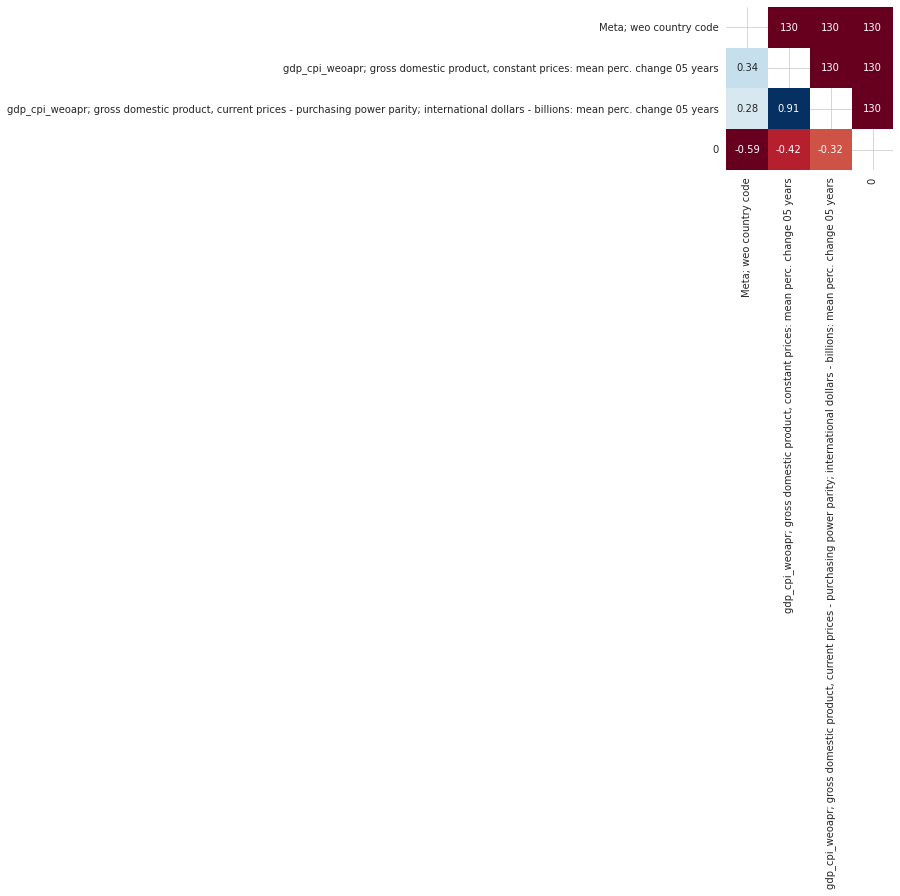

3 val


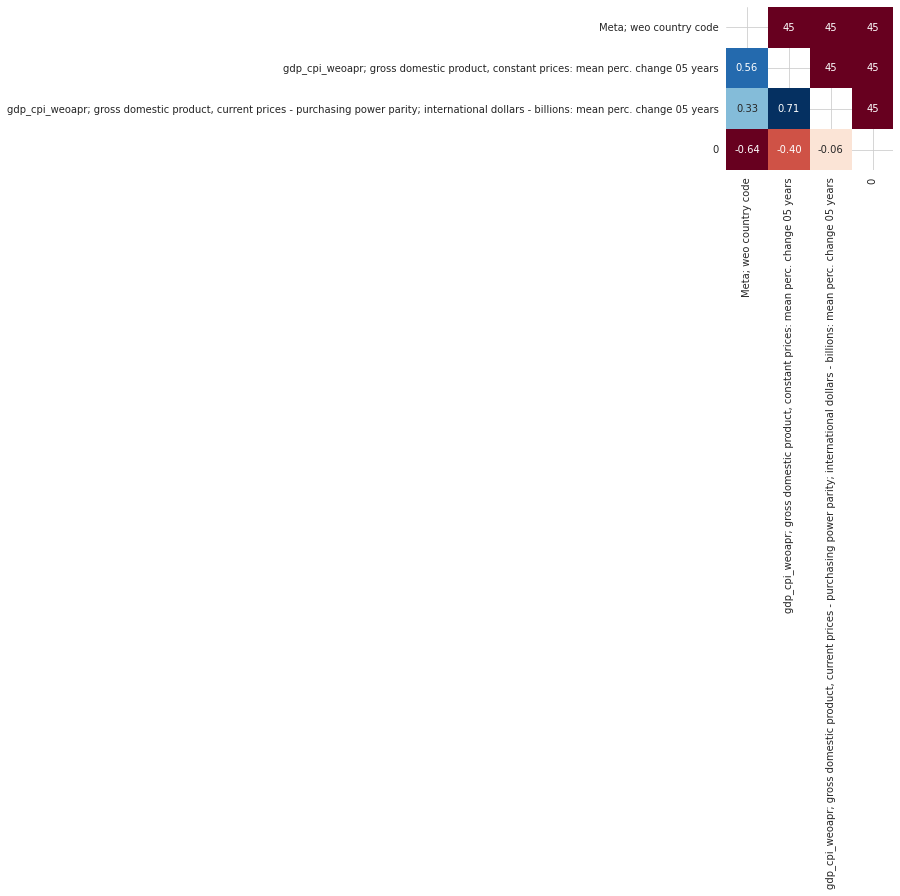

3 test


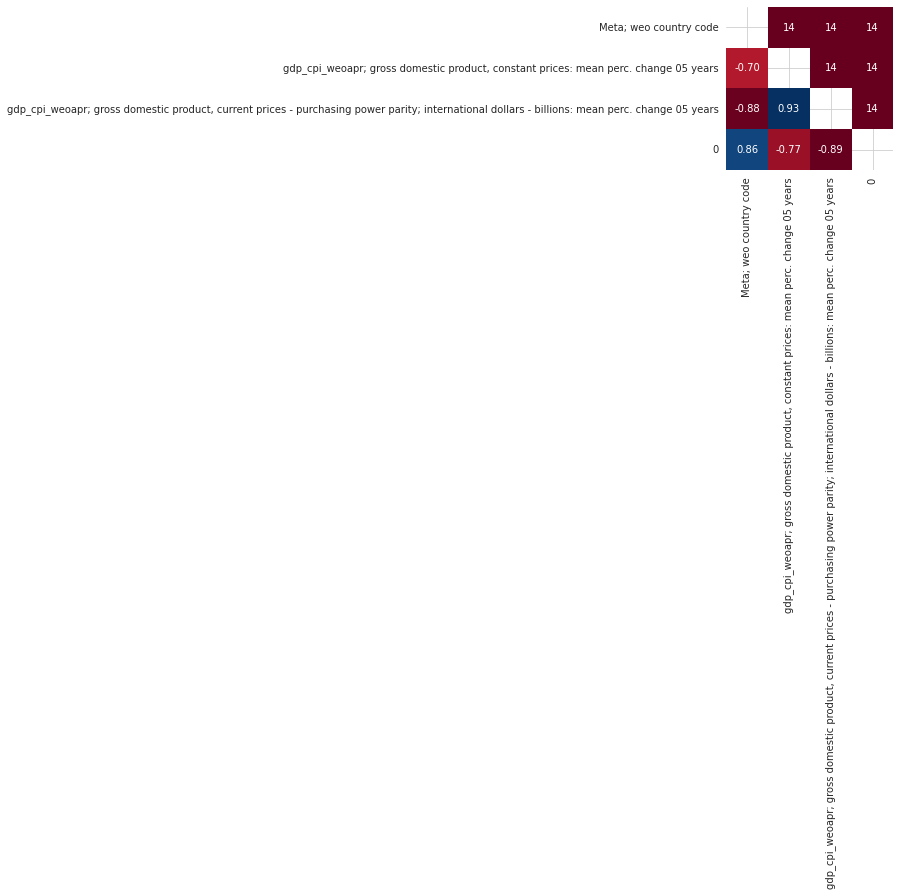

3 all


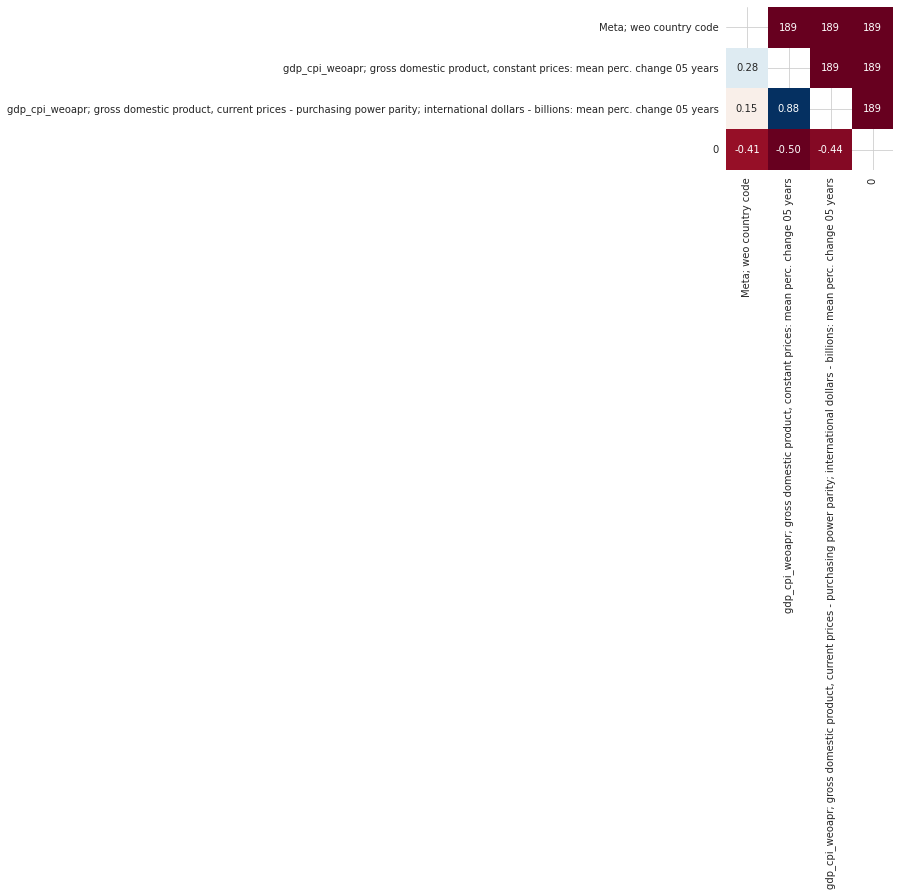

4
train set ['Ethiopia' 'Kenya' 'Malawi' 'Mali' 'Niger' 'Nigeria'
 'United Republic of Tanzania' 'Uganda' 'Zambia' 'Rwanda' 'Guinea'
 'Sierra Leone' 'Somalia' 'South Sudan' 'Democratic Republic of the Congo'
 'Burundi' 'Cameroon']
val set ['Djibouti' 'Chad' 'Sudan' 'Yemen' 'Madagascar']
test set ['Mauritania' 'Mozambique' 'Zimbabwe' 'Burkina Faso' 'Liberia']
Shapes (110, 4) (38, 4) (41, 4)
4 train


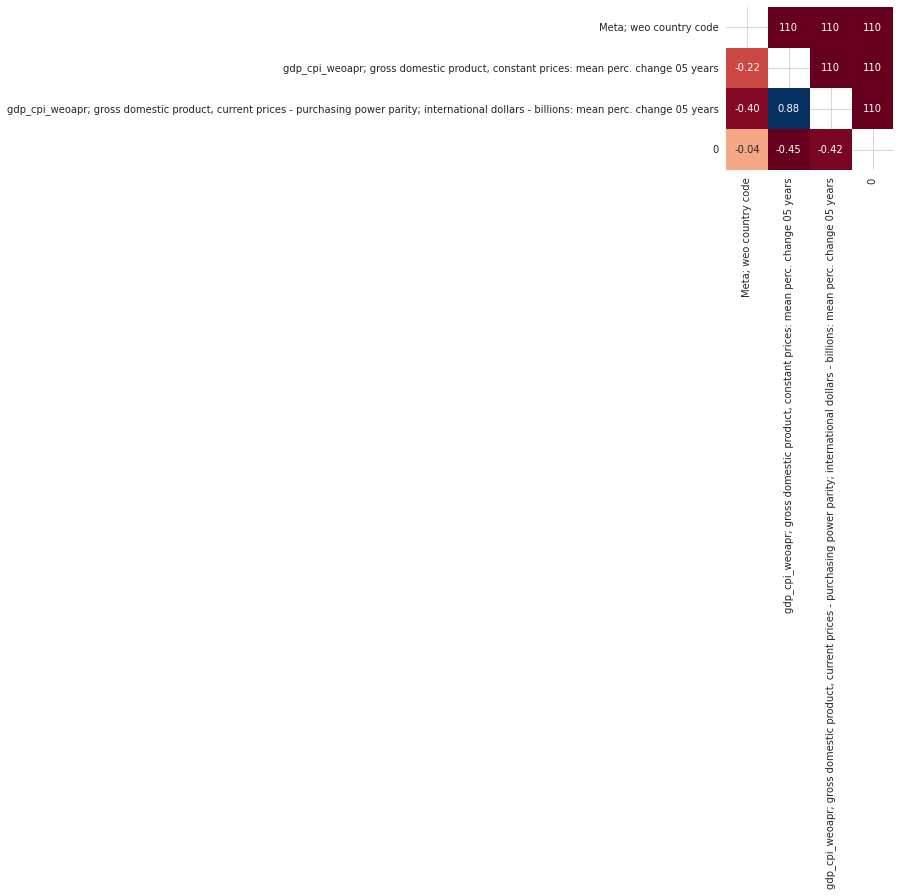

4 val


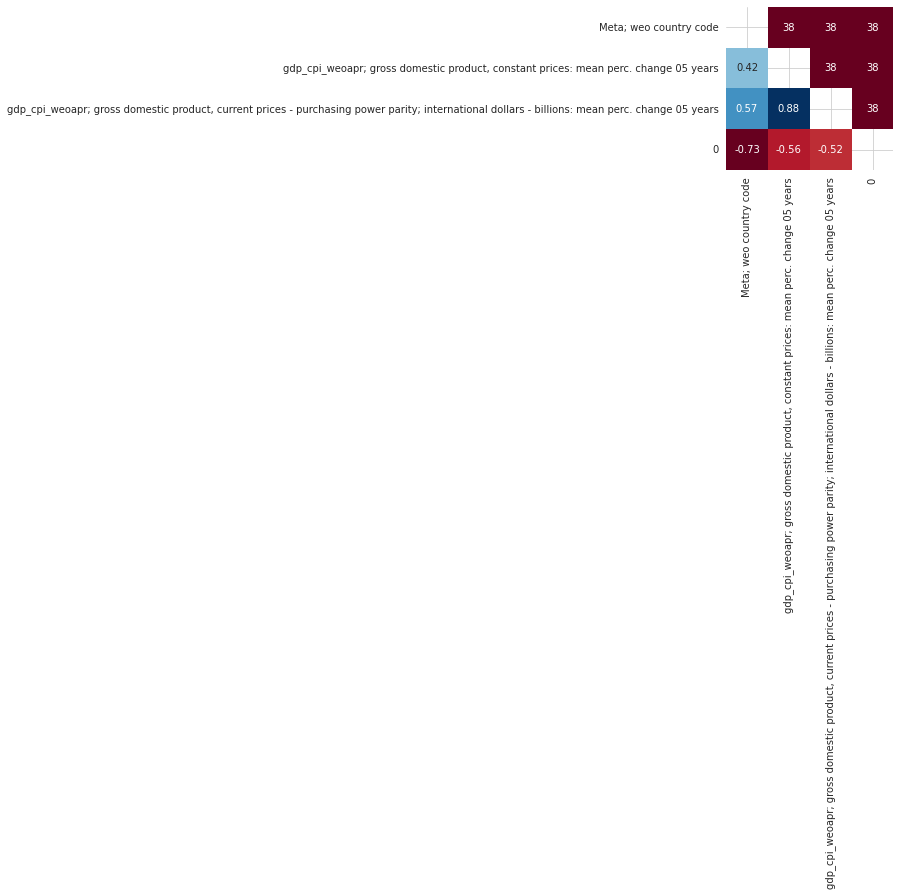

4 test


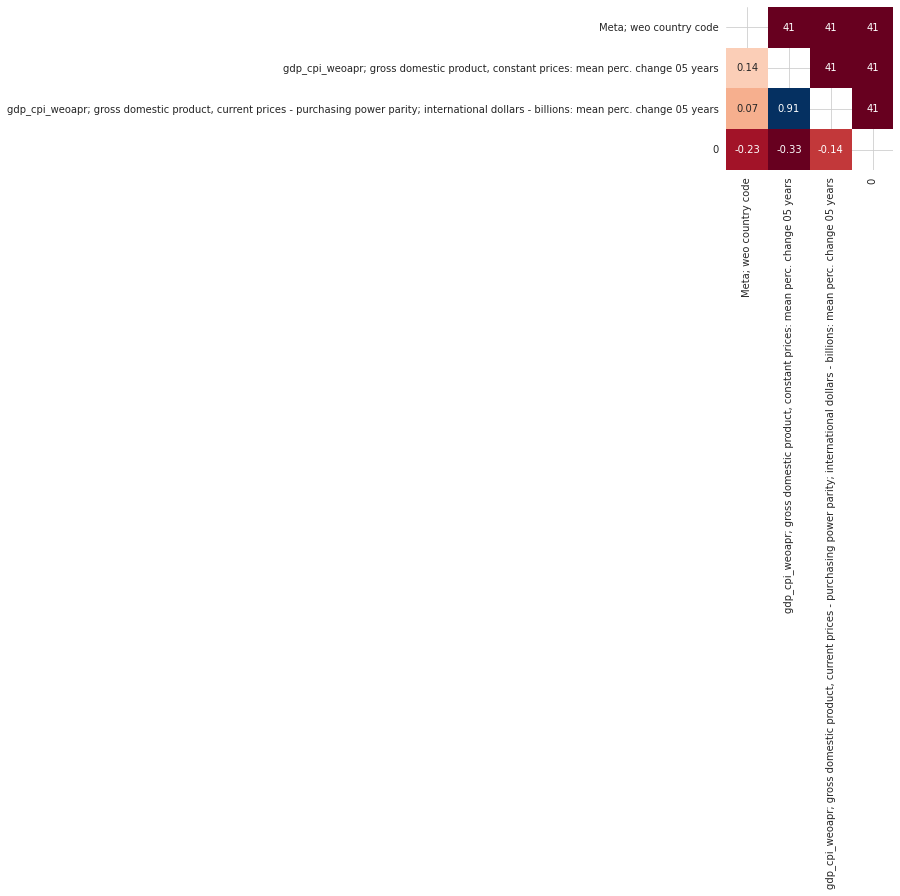

4 all


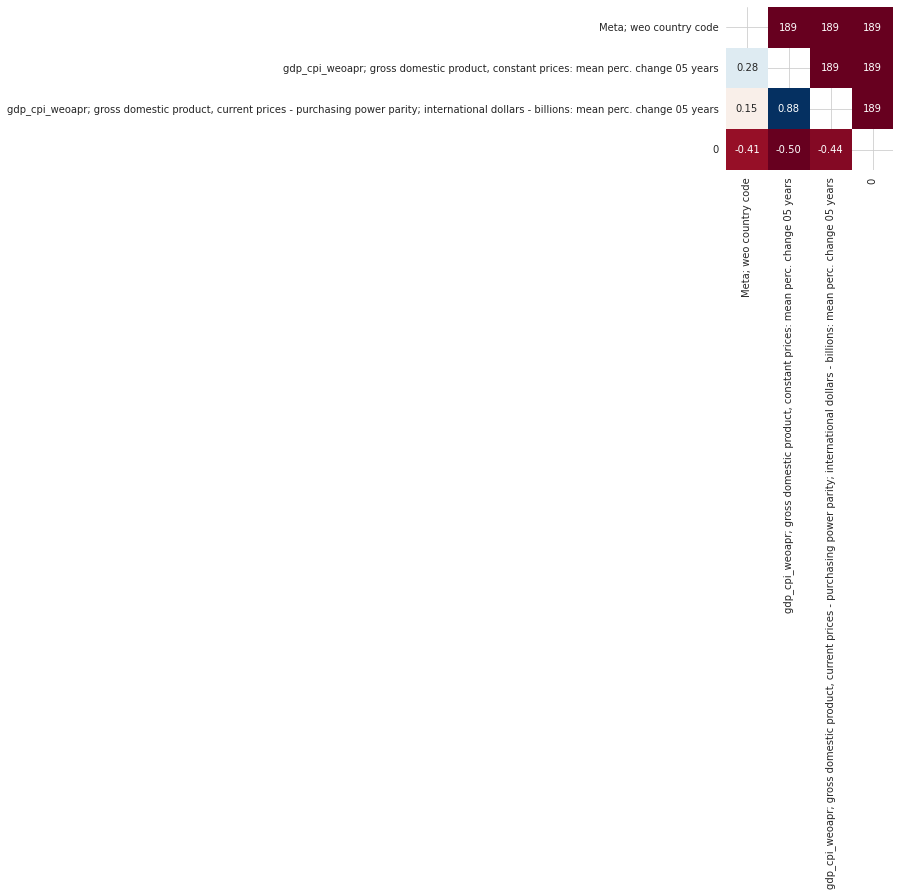

(189, 2)
(189, 2)
(189,)


,index,RMSE,nRMSE,R2,Correlation,scale_numerical_data,scale_all_data,leave_out_encodings,zero_one_scale_categorical,scale_labels,...,print_col,drop_perc,epochs,use_sustainbench,test_mode,use_fs_as_input,test_function_to_use,use_additional_subset,neurons_first_layer,label_col
0,90,0.390997,0.966240,0.066381,0.419937,False,True,False,False,True,...,Meta; adm0_gaul,20,100,False,False,True,mse,True,256,FS; IPC: 0-6m: mean
1,80,0.401993,0.956880,0.084381,0.418115,False,True,False,False,True,...,Meta; adm0_gaul,20,100,False,False,True,mse,True,256,FS; IPC: 0-6m: mean
2,70,0.405475,0.964243,0.070235,0.406883,False,True,False,False,True,...,Meta; adm0_gaul,20,100,False,False,True,mse,True,256,FS; IPC: 0-6m: mean
3,60,0.454729,0.986187,0.027435,0.352423,False,True,False,False,True,...,Meta; adm0_gaul,20,100,False,False,True,mse,True,256,FS; IPC: 0-6m: mean
4,50,0.496159,1.008574,-0.017221,0.303404,False,True,False,False,True,...,Meta; adm0_gaul,20,100,False,False,True,mse,True,256,FS; IPC: 0-6m: mean
5,40,0.495208,1.006628,-0.013300,0.307017,False,True,False,False,True,...,Meta; adm0_gaul,20,100,False,False,True,mse,True,256,FS; IPC: 0-6m: mean
6,Overall,0.496539,0.998437,0.003124,0.319724,False,True,False,False,True,...,Meta; adm0_gaul,20,100,False,False,True,mse,True,256,FS; IPC: 0-6m: mean


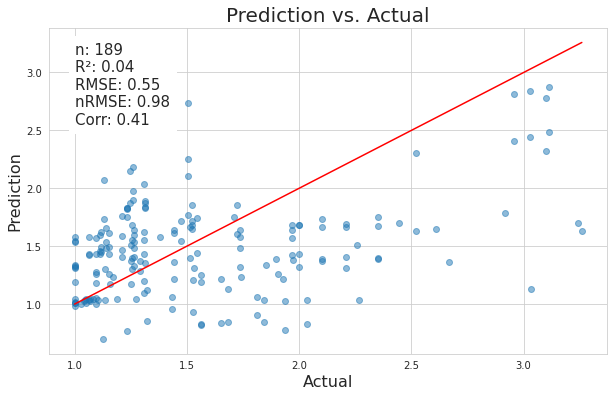

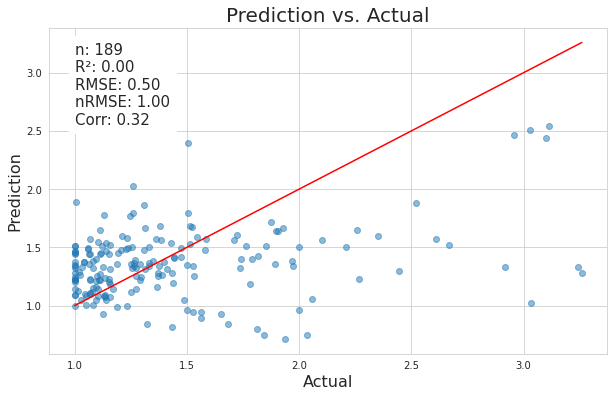

In [34]:
label_cols = [c for c in df.columns if 'FS; IPC' in c]
if use_fs_as_input:
    label_cols = [c for c in label_cols if 'FS; IPC: -1-0y: mean' not in c]

input_df2 = df.drop(columns=label_cols)

if use_additional_subset:
    remain_col = [
                'Meta; adm0_gaul', 
                'gdp_cpi_weoapr; gross domestic product, constant prices: mean perc. change 05 years',
                'Meta; weo country code',
                #   'gdp_cpi_weoapr; gross domestic product based on purchasing-power-parity (ppp) share of world total - percent: mean perc. change 05 years',
                #   'gdp_cpi_weoapr; gross domestic product, deflator - index: mean perc. change 05 years',
                #   'gdp_cpi_weoapr; inflation, average consumer prices: mean perc. change 05 years',
                  'gdp_cpi_weoapr; gross domestic product, current prices - purchasing power parity; international dollars - billions: mean perc. change 05 years'
                #   'FS; IPC: -1-0y: mean',
                  
                  ]
    input_df2 = input_df2.drop(columns=[c for c in input_df2.columns if c not in remain_col])

label_cols = [c for c in label_cols if 'FS; IPC: -1-0y' not in c]

num_cols = [c for c in input_df2.columns if 'DHS Num;' in c or c == 'Meta; Year' or 'FS; IPC' in c]

##Corr Matrix
corr_mtrx_df = pd.concat([input_df2, df[label_cols[0]]], axis=1)
create_correlation_matrix(corr_mtrx_df.select_dtypes(include=[np.number]), f"{out_dir}Correlation_matrix.png")

print('label_cols', label_cols)
print('num_cols', num_cols)
print('input_df2', input_df2.columns)
# options['in cols'] = input_df2.columns
scaler_l = []
history_l = []
y_l = []
y_pred_l = []
model_l = []
amount_inputs = []
amount_cols = []

if os.path.exists(result_csv_f) and not overwrite_results:
    final_result_df = pd.read_csv(result_csv_f)
else:
    final_result_df = pd.DataFrame()

regularizer = None
if regularizer_type == 'l2':
    regularizer = regularizers.l2(regularizer_value)
elif regularizer_type == 'l1':
    regularizer = regularizers.l1(regularizer_value)

results_d = defaultdict(list)
results_f_d = defaultdict(list)
for nr, col in enumerate(label_cols[0:1]):
    all_results_dfs = []
    all_val_results_dfs = []
    print(nr, col, len(df[col]))
    options['label_col'] = col
    labels = df[col]
    labels = labels.dropna()
    # labels = labels[labels < 4]
    labels_ind = labels.index
    scaler = False
    if scale_labels:
        # scale the labels
        scaler = StandardScaler()
        labels = scaler.fit_transform(labels.values.reshape(-1, 1))
        labels = pd.Series(labels.flatten(), index=labels_ind)
    input_df = input_df2.loc[labels.index]
    
    # if model_n == 'nn':
    #drop NaNs
    input_df = input_df.dropna(axis=0)
    input_ind = input_df.index
    labels = labels.loc[input_ind]

    #not dropping NaNs, since model can work like that
    print('lens', len(labels), len(input_df))
    print('cols', len(input_df.columns))
    if len(input_df) < 10:
        continue
    
    amount_cols.append(len(input_df.columns))
    assert(labels.index.equals(input_df.index))
    amount_inputs.append(len(input_df))
    scaler_l.append(scaler)

    scaler2 = StandardScaler()    
    if scale_all_data:
        drop_cols = ['Meta; adm0_gaul', 'Meta; GEID_init']
        if leave_out_encodings:
            cols = [c for c in input_df.columns if not any([True for drop_c in ['Meta one-hot encoding;', 'Meta frequency encoding;']
                                                            + drop_cols if drop_c in c])]
            input_df[cols] = scaler2.fit_transform(input_df[cols])
        else:
            cols = [c for c in input_df.columns if c not in drop_cols]
            input_df[cols] = scaler2.fit_transform(input_df[cols])
    else:
        if scale_numerical_data:
            input_df[num_cols] = scaler2.fit_transform(input_df[num_cols])
        
        if zero_one_scale_categorical:
            scaler3 = MinMaxScaler()
            cols = [c for c in input_df.columns if 'DHS Cat;' in c]
            input_df[cols] = scaler3.fit_transform(input_df[cols])
    
    # input_df.to_csv(f"{input_dir}Prefiltered_normalized_grouped_df_V3_{dataset_type}_{group_by_col}_{urban_rural_all_mode}_m_{col}.csv")
       
    fold_gen = fold_generator_3_independent_indices(input_df, fold_by, n_splits=5)
    # Iterate over each fold
    for fold, (train_index, val_index, test_index) in enumerate(fold_gen):
        assert(labels.index.equals(input_df.index))

        X_train, X_val, X_test = input_df.loc[train_index], input_df.loc[val_index], input_df.loc[test_index]
        y_train, y_val, y_test = labels.loc[train_index], labels.loc[val_index], labels.loc[test_index]          
        y_test_index = y_test.index
        print(fold)
        try:
            print('train set', X_train[print_col].unique())
            print('val set', X_val[print_col].unique())
            print('test set', X_test[print_col].unique())
            print('Shapes', X_train.shape, X_val.shape, X_test.shape)
        except KeyError:
            print('Shapes', X_train.shape, X_val.shape, X_test.shape)
        # print(X_train)
        # print(y_train)
        # drop cols
        drop_cols = ['Meta; adm0_gaul', 'Meta; GEID_init']
        drop_cols = [c for c in drop_cols if c in X_train.columns]
        if 'Meta; rounded year' in X_train.columns:
            drop_cols.append('Meta; rounded year')
        X_train = X_train.drop(columns=drop_cols)
        X_val = X_val.drop(columns=drop_cols)
        X_test = X_test.drop(columns=drop_cols)
        
        n_components = False
        if use_pca:
            # create PCA
            n_components = use_pca
            if use_pca == True:
                n_components = 0.98
            pca = PCA(n_components=n_components)
            pca = pca.fit(X_train)
            X_test = pca.transform(X_test)
            X_val = pca.transform(X_val)
            X_train = pca.transform(X_train)
            # Calculate the cumulative explained variance
            cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
            print('PCA', X_train.shape, X_val.shape, X_test.shape)
            print('Cumulative explained variance', cumulative_explained_variance)
            print(len(cumulative_explained_variance))
            
        all_dfs = []
        for name, X, y in zip(['train', 'val','test'], [X_train, X_val, X_test], [y_train, y_val, y_test]):
            ##Corr Matrix
            corr_mtrx_df = pd.concat([X, y], axis=1)
            print(fold, name)
            create_correlation_matrix(corr_mtrx_df, f"{out_dir}Correlation_matrix_fold{fold}_{name}.png")
            all_dfs.append(corr_mtrx_df)
        corr_mtrx_all = pd.concat(all_dfs)
        print(fold, 'all')
        create_correlation_matrix(corr_mtrx_all, f"{out_dir}Correlation_matrix_fold{fold}_all.png")
        
        history = False
        if model_n == 'xgb':
            # Initialize the XGBoost model
            model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
            # Train the model
            model.fit(X_train, y_train)
        elif model_n == 'linear':
            # Initialize the Linear Regression model
            model = LinearRegression()
            # Train the model
            model.fit(X_train, y_train)
        elif model_n == 'nn':
            if use_3_layer_nn:
                # Define the model
                model = Sequential()
                model.add(Dense(neurons_first_layer, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=regularizer))
                model.add(Dense(64, activation='relu', kernel_regularizer=regularizer))
                # model.add(Dense(32, activation='relu', kernel_regularizer=regularizer))
                if add_dropout:
                    model.add(Dropout(add_dropout))
                model.add(Dense(1, activation='linear'))
            else:
                # Define the model
                model = Sequential()
                model.add(Dense(neurons_first_layer, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=regularizer))
                if add_dropout:
                    model.add(Dropout(add_dropout))
                model.add(Dense(1, activation='linear'))
                
            # Compile the model
            model.compile(optimizer=Adam(learning_rate=0.001), loss=loss_function, metrics=[loss_function])

            checkpoint_n = 'best_model.keras'
            # Define the ModelCheckpoint callback
            checkpoint = ModelCheckpoint(checkpoint_n, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
            early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min')
            
            # Train the model
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_val, y_val), callbacks=[checkpoint, early_stopping])
            history_l.append(history)
                       
            if load_best_model:
                # Load the best model
                print('loading best model')
                model.load_weights(checkpoint_n)
            
            # Evaluate the model on the test set
            test_loss, test_rmse = model.evaluate(X_val, y_val)
            print(f'Val Loss: {test_loss}')
            print(f'Val RMSE: {test_rmse}')
            
            test_loss, test_rmse = model.evaluate(X_test, y_test)
            print(f'Test Loss: {test_loss}')
            print(f'Test RMSE: {test_rmse}')
        
            create_history_figures(history, f"{out_dir}", fold)
        
        for nrx, (X, y) in enumerate(zip([X_val, X_test], [y_val, y_test])):
            # Predict on the test set
            y_pred = model.predict(X)
            y_index = y.index
            y = np.array(y)
            if y.ndim == 1:
                y = y.reshape(-1, 1)
            if y_pred.ndim == 1:
                y_pred = y_pred.reshape(-1, 1)
            
            # Inverse transform the predictions
            if scale_labels:
                y_pred = scaler.inverse_transform(y_pred)
                y = scaler.inverse_transform(y)
                    
            assert len(y) == len(y_pred)
            # Create a DataFrame with 'Actual' and 'Prediction' columns
            results_df = pd.DataFrame({
                'Actual': y.flatten(),
                'Prediction': y_pred.flatten()
            }, index=y_index)
            
            # create_scatterplot(results_df, f"{out_dir}Scatterplot_{col}_fold{fold}.png")
            if nrx == 1:
                all_results_dfs.append(results_df)
            if nrx == 0:
                all_val_results_dfs.append(results_df)
        
        if write_PDP_plots:
            # Create partial dependence plots
            create_PDP_plots(X_test, model, f"{input_dir}DHS_PDP_NN/", fold)
        
        if test_mode:
            print(f"{test_mode}: breaking")
            break
        
    all_result_df = pd.concat(all_results_dfs)
    all_val_result_df = pd.concat(all_val_results_dfs)
    print(all_result_df.shape)
    print(all_val_result_df.shape)
    print(labels.shape)

    missing_mask = missing_mask.loc[all_result_df.index]
    final_p_res_df = metrices_weighted_available_data(all_result_df, missing_mask, drop_perc=drop_perc)

    # Add options to every row of final_p_res_df
    final_p_res_df = final_p_res_df.assign(**options)
    # print('new', final_p_res_df)
    # print('old', final_result_df)
    create_scatterplot(all_val_result_df, f"{out_dir}Scatterplot_Val_{col}.png")
    create_scatterplot(all_result_df, f"{out_dir}Scatterplot_Test_{col}.png")

    # Add results_d to result_df
    final_result_df = pd.concat([final_p_res_df, final_result_df])
    
final_result_df.to_csv(result_csv_f, index=False)
final_p_res_df.head(50)

In [35]:
final_p_res_df.head(50)

,index,RMSE,nRMSE,R2,Correlation,scale_numerical_data,scale_all_data,leave_out_encodings,zero_one_scale_categorical,scale_labels,...,print_col,drop_perc,epochs,use_sustainbench,test_mode,use_fs_as_input,test_function_to_use,use_additional_subset,neurons_first_layer,label_col
0,90,0.390997,0.966240,0.066381,0.419937,False,True,False,False,True,...,Meta; adm0_gaul,20,100,False,False,True,mse,True,256,FS; IPC: 0-6m: mean
1,80,0.401993,0.956880,0.084381,0.418115,False,True,False,False,True,...,Meta; adm0_gaul,20,100,False,False,True,mse,True,256,FS; IPC: 0-6m: mean
2,70,0.405475,0.964243,0.070235,0.406883,False,True,False,False,True,...,Meta; adm0_gaul,20,100,False,False,True,mse,True,256,FS; IPC: 0-6m: mean
3,60,0.454729,0.986187,0.027435,0.352423,False,True,False,False,True,...,Meta; adm0_gaul,20,100,False,False,True,mse,True,256,FS; IPC: 0-6m: mean
4,50,0.496159,1.008574,-0.017221,0.303404,False,True,False,False,True,...,Meta; adm0_gaul,20,100,False,False,True,mse,True,256,FS; IPC: 0-6m: mean
5,40,0.495208,1.006628,-0.013300,0.307017,False,True,False,False,True,...,Meta; adm0_gaul,20,100,False,False,True,mse,True,256,FS; IPC: 0-6m: mean
6,Overall,0.496539,0.998437,0.003124,0.319724,False,True,False,False,True,...,Meta; adm0_gaul,20,100,False,False,True,mse,True,256,FS; IPC: 0-6m: mean


In [36]:
final_result_df

,index,RMSE,nRMSE,R2,Correlation,scale_numerical_data,scale_all_data,leave_out_encodings,zero_one_scale_categorical,scale_labels,...,print_col,drop_perc,epochs,use_sustainbench,test_mode,use_fs_as_input,test_function_to_use,use_additional_subset,neurons_first_layer,label_col
0,90,0.390997,0.966240,0.066381,0.419937,False,True,False,False,True,...,Meta; adm0_gaul,20,100,False,False,True,mse,True,256.0,FS; IPC: 0-6m: mean
1,80,0.401993,0.956880,0.084381,0.418115,False,True,False,False,True,...,Meta; adm0_gaul,20,100,False,False,True,mse,True,256.0,FS; IPC: 0-6m: mean
2,70,0.405475,0.964243,0.070235,0.406883,False,True,False,False,True,...,Meta; adm0_gaul,20,100,False,False,True,mse,True,256.0,FS; IPC: 0-6m: mean
3,60,0.454729,0.986187,0.027435,0.352423,False,True,False,False,True,...,Meta; adm0_gaul,20,100,False,False,True,mse,True,256.0,FS; IPC: 0-6m: mean
4,50,0.496159,1.008574,-0.017221,0.303404,False,True,False,False,True,...,Meta; adm0_gaul,20,100,False,False,True,mse,True,256.0,FS; IPC: 0-6m: mean
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,Overall,0.318320,1.130409,-0.277824,0.069834,False,True,False,False,True,...,Meta; adm0_gaul,20,30,False,False,NaN,NaN,NaN,NaN,NaN
431,Overall,0.230273,0.817739,0.331303,0.608109,False,True,False,False,True,...,Meta; adm0_gaul,20,30,False,False,NaN,NaN,NaN,NaN,NaN
432,Overall,0.125175,0.444520,0.802402,0.896552,False,True,False,False,True,...,Meta; adm0_gaul,20,30,False,False,NaN,NaN,NaN,NaN,NaN
433,Overall,0.133423,0.473807,0.775507,0.896742,False,True,False,False,True,...,Meta; adm0_gaul,20,30,False,False,NaN,NaN,NaN,NaN,NaN
